# Import the necessary modules

In [1]:
! pip3 install torch 

In [3]:
!pip uninstall torchtext -y
!pip install -U torchtext==0.8

Found existing installation: torchtext 0.8.0
Uninstalling torchtext-0.8.0:
  Successfully uninstalled torchtext-0.8.0
  Using cached torchtext-0.8.0-cp38-cp38-macosx_10_9_x86_64.whl (1.5 MB)


In [2]:
import torch
import torch.nn as nn

from model.Model import Seq2Seq
from model.Encoder import Encoder
from model.Decoder import Decoder
from model.VisAwareTranslation import translate_sentence_with_guidance, postprocessing, get_all_table_columns
from preprocessing.build_vocab import build_vocab
from utilities.vis_rendering import VisRendering

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# from vega import VegaLite

import random
import numpy as np
import pandas as pd
import math

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device = torch.device('cpu')  # cpu or gpu? depend on your computational environment.

# Build vocab

In [5]:
print("------------------------------\n| Build vocab start ... | \n------------------------------")
SRC, TRG, TOK_TYPES, BATCH_SIZE, train_iterator, valid_iterator, test_iterator, my_max_length = build_vocab(
    data_dir='./dataset/dataset_final/',
    db_info='./dataset/database_information.csv',
    batch_size=128,
    max_input_length=128
)
print("------------------------------\n| Build vocab end ... | \n------------------------------")

------------------------------
| Build vocab start ... | 
------------------------------


/Users/yuyu/anaconda3/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/Users/yuyu/anaconda3/lib/python3.8/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/Users/yuyu/anaconda3/lib/python3.8/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release note

------------------------------
| Build vocab end ... | 
------------------------------


/Users/yuyu/anaconda3/lib/python3.8/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


# Construct ncNet model

In [6]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256  # it equals to embedding dimension 
ENC_LAYERS = 3 
DEC_LAYERS = 3 
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM,
              HID_DIM,
              ENC_LAYERS,
              ENC_HEADS,
              ENC_PF_DIM,
              ENC_DROPOUT,
              device,
              TOK_TYPES,
              my_max_length
              )

dec = Decoder(OUTPUT_DIM,
              HID_DIM,
              DEC_LAYERS,
              DEC_HEADS,
              DEC_PF_DIM,
              DEC_DROPOUT,
              device,
              my_max_length
              )

SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)  # define the transformer-based ncNet

# Load the trained ncNet model

In [7]:
model.load_state_dict(torch.load('./save_models/model_best.pt', map_location=torch.device('cpu'))) ### map to cpu

<All keys matched successfully>

# Testing

## read the testing dataset

In [8]:
db_tables_columns = get_all_table_columns('./dataset/db_tables_columns.json')

test_df = pd.read_csv('./dataset/dataset_final/test.csv')

# shuffle your dataframe in-place and reset the index
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [9]:
test_df.head()

tvBench_id                      db_id chart    hardness  \
0              790        cre_Doc_Tracking_DB   Pie        Easy   
1             1151        document_management   Pie        Easy   
2  888@x_name@DESC             cre_Theme_park   Bar      Medium   
3   859@y_name@ASC  cre_Drama_Workshop_Groups   Bar      Medium   
4  1593@y_name@ASC                       hr_1   Bar  Extra Hard   

                                               query  \
0  Visualize PIE SELECT Location_Code , count(*) ...   
1  Visualize PIE SELECT role_code , count(*) FROM...   
2  Visualize BAR SELECT How_to_Get_There , COUNT(...   
3  Visualize BAR SELECT Product_Name , avg(Produc...   
4  Visualize BAR SELECT HIRE_DATE , AVG(SALARY) F...   

                                            question  \
0  What is the code of each location and the numb...   
1  What are the different role codes for users , ...   
2  Show different ways to get to attractions and ...   
3  Give me a bar chart for mean product price of ...   
4  For those employees whose salary is in the ran...   

                                 mentioned_columns  \
0                 document_locations location_code   
1                                  users role_code   
2        tourist_attractions how_to_get_there name   
3              products product_name product_price   
4  employees hire_date salary last_name first_name   

                                    mentioned_values  \
0                                              b n e   
1                                                NaN   
2                                      walk bus cafe   
3                                               film   
4  Fox Bull Chen Lee Gee Lisa Banda King Ande Bel...   

                                      query_template  \
0  visualize pie select [x], [agg(y)] from [d] wh...   
1  visualize pie select [x], [agg(y)] from [d] wh...   
2  visualize [c] select [x], [agg(y)] from touris...   
3  visualize bar select [x], [agg(y)] from produc...   
4  visualize bar select [x], [agg(y)] from employ...   

                                              source  \
0  <nl> What is the code of each location and the...   
1  <nl> What are the different role codes for use...   
2  <nl> Show different ways to get to attractions...   
3  <nl> Give me a bar chart for mean product pric...   
4  <nl> For those employees whose salary is in th...   

                                              labels  \
0  Visualize PIE SELECT Location_Code , count(*) ...   
1  Visualize PIE SELECT role_code , count(*) FROM...   
2  Visualize BAR SELECT How_to_Get_There , COUNT(...   
3  Visualize BAR SELECT Product_Name , avg(Produc...   
4  Visualize BAR SELECT HIRE_DATE , AVG(SALARY) F...   

                                         token_types  
0  nl nl nl nl nl nl nl nl nl nl nl nl nl nl nl n...  
1  nl nl nl nl nl nl nl nl nl nl nl nl nl nl nl n...  
2  nl nl nl nl nl nl nl nl nl nl nl nl nl nl nl n...  
3  nl nl nl nl nl nl nl nl nl nl nl nl nl nl nl n...  
4  nl nl nl nl nl nl nl nl nl nl nl nl nl nl nl n...

## testing covid19 cases

In [10]:
covid19_df = test_df[test_df['db_id'] == 'covid19'].sample(frac=1).reset_index(drop=True)

In [11]:
len(covid19_df)

56

In [12]:
covid19_df.head()

tvBench_id    db_id        chart  hardness  \
0  covid19_20  covid19          Bar  hardness   
1  covid19_11  covid19          Bar  hardness   
2  covid19_12  covid19          Bar  hardness   
3  covid19_27  covid19  Stacked Bar  hardness   
4   covid19_8  covid19          Bar  hardness   

                                               query  \
0  Visualize bar SELECT states , number FROM us_s...   
1  Visualize bar SELECT states , number from us_s...   
2  Visualize bar SELECT states , number from us_s...   
3  Visualize bar SELECT states , cases , sum(numb...   
4  Visualize bar SELECT date , sum(number) FROM u...   

                                            question  \
0  Create a bar chart showing the top 5 states wi...   
1  Plot a bar chart for the number of recovered p...   
2  Plot a bar chart for the number of died people...   
3  for 2021-01-01 , I want to know the total numb...   
4  Show a bar chart about the deaths cases of all...   

                    mentioned_columns  \
0         us_states states cases date   
1  us_states number states date cases   
2        us_states number states date   
3  us_states cases number states date   
4         us_states date states cases   

                                    mentioned_values  \
0  recovered 2021-01-01 2021-03-01 2021-01-03 202...   
1  recovered 2021-01-01 2021-03-01 2021-01-03 202...   
2  2021-01-01 2021-01-04 2021-01-11 2021-01-09 20...   
3  2021-01-01 2021-01-07 2021-01-03 2021-03-01 20...   
4  2021-03-08 2020-04-12 deaths 2020-05-12 2021-0...   

                                      query_template  \
0  visualize bar select [x], [agg(y)] from us_sta...   
1  visualize [c] select [x], [agg(y)] from us_sta...   
2  visualize bar select [x], [agg(y)] from us_sta...   
3  visualize bar select [x], [agg(y)] from [d] wh...   
4  visualize bar select [x], [agg(y)] from [d] wh...   

                                              source  \
0  <nl> Create a bar chart showing the top 5 stat...   
1  <nl> Plot a bar chart for the number of recove...   
2  <nl> Plot a bar chart for the number of died p...   
3  <nl> for 2021-01-01 , I want to know the total...   
4  <nl> Show a bar chart about the deaths cases o...   

                                              labels  \
0  Visualize bar SELECT states , number FROM us_s...   
1  Visualize bar SELECT states , number from us_s...   
2  Visualize bar SELECT states , number from us_s...   
3  Visualize bar SELECT states , cases , sum(numb...   
4  Visualize bar SELECT date , sum(number) FROM u...   

                                         token_types  
0  nl nl nl nl nl nl nl nl nl nl nl nl nl nl nl n...  
1  nl nl nl nl nl nl nl nl nl nl nl nl nl nl nl n...  
2  nl nl nl nl nl nl nl nl nl nl nl nl nl nl nl n...  
3  nl nl nl nl nl nl nl nl nl nl nl nl nl nl nl n...  
4  nl nl nl nl nl nl nl nl nl nl nl nl nl nl nl n...


[Database]: covid19
[NL Question]: Create a bar chart showing the top 5 states with the most recovered cases until 2021-01-01
[Chart Template]: visualize bar select [x], [agg(y)] from us_states where [w] group by [y] bin [x] by [i] order by [y] desc
[Predicted VIS Query]: visualize bar select states , number from us_states where date = '2021-01-01' and cases = 'recovered' order by number desc limit 5
[The Ground Truth VIS Query]: Visualize bar SELECT states , number FROM us_states WHERE date = '2021-01-01' and cases = 'recovered' ORDER BY number DESC LIMIT 5
The Predicted VIS:


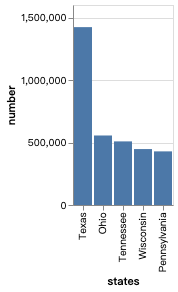




[Database]: covid19
[NL Question]: Plot a bar chart for the number of recovered people on 2021-01-01 in each state , and sort Y-axis in desc order
[Chart Template]: visualize [c] select [x], [agg(y)] from us_states where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select states , number from us_states where cases = 'recovered' and date = '2021-01-01' group by states order by number desc
[The Ground Truth VIS Query]: Visualize bar SELECT states , number from us_states WHERE cases = 'recovered' and date = '2021-01-01' GROUP BY states ORDER BY number DESC
The Predicted VIS:


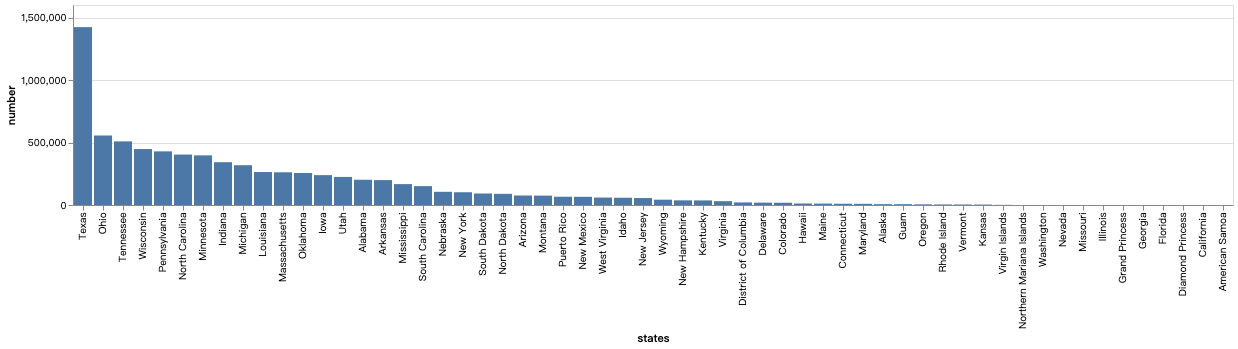




[Database]: covid19
[NL Question]: Plot a bar chart for the number of died people on 2021-01-01 in each state , and sort Y-axis in desc order
[Chart Template]: visualize bar select [x], [agg(y)] from us_states where [w] group by [y] bin [x] by [i] order by [y] desc
[Predicted VIS Query]: visualize bar select states , number from us_states where cases = 'deaths' and date = '2021-01-01' group by states order by number desc
[The Ground Truth VIS Query]: Visualize bar SELECT states , number from us_states WHERE cases = 'deaths' and date = '2021-01-01' GROUP BY states ORDER BY number DESC
The Predicted VIS:


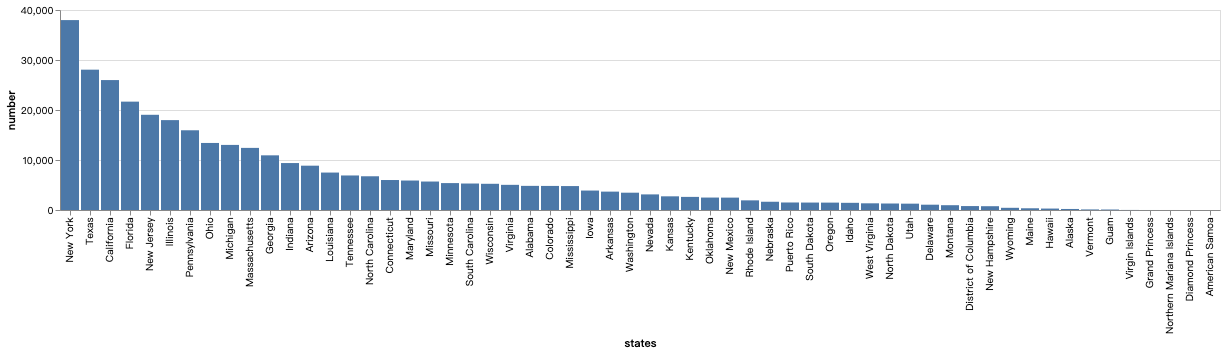




[Database]: covid19
[NL Question]: for 2021-01-01 , I want to know the total number by different cases for each state with a stacked bar chart
[Chart Template]: visualize bar select [x], [agg(y)] from [d] where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select states , cases , sum(number) from us_states where date = '2021-01-01' group by states , cases
[The Ground Truth VIS Query]: Visualize bar SELECT states , cases , sum(number) FROM us_states WHERE date = '2021-01-01' GROUP BY states , cases
The Predicted VIS:


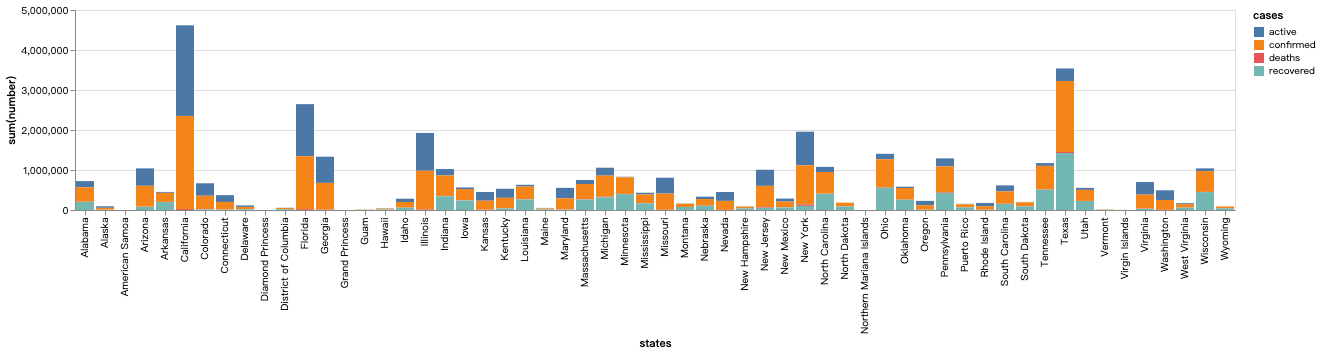




[Database]: covid19
[NL Question]: Show a bar chart about the deaths cases of all states by ranging the date from 2020-04-12 to 2021-03-08
[Chart Template]: visualize bar select [x], [agg(y)] from [d] where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select date , cases , sum(number) from us_states where date >= '2020-04-12' and date <= '2021-03-08' and cases = 'deaths' group by date
[The Ground Truth VIS Query]: Visualize bar SELECT date , sum(number) FROM us_states WHERE date >= '2020-04-12' and date <= '2021-03-08' and cases = 'deaths' GROUP BY date
The Predicted VIS:


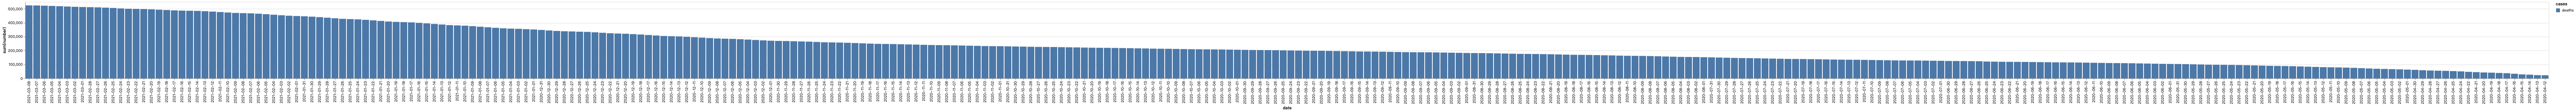




[Database]: covid19
[NL Question]: draw a stacked bar to show the total number by different cases for each state on 2021-01-01
[Chart Template]: visualize [c] select [x], [agg(y)] from us_states where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select states , cases , sum(number) from us_states where date = '2021-01-01' group by states , cases
[The Ground Truth VIS Query]: Visualize bar SELECT states , cases , sum(number) FROM us_states WHERE date = '2021-01-01' GROUP BY states , cases
The Predicted VIS:


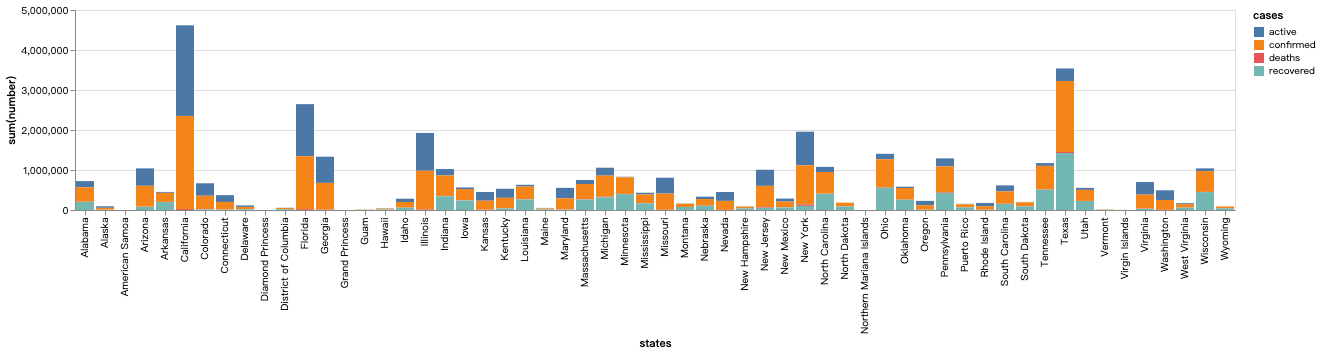




[Database]: covid19
[NL Question]: A line chart showing the confirmed , deaths , and recovered cases of the Utah state
[Chart Template]: visualize line select [x], [agg(y)] from [d] where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize line select date , cases , number from us_states where states = 'utah' group by date , cases
[The Ground Truth VIS Query]: Visualize line SELECT date , cases , number from us_states WHERE states = 'Utah' GROUP BY date , cases
The Predicted VIS:


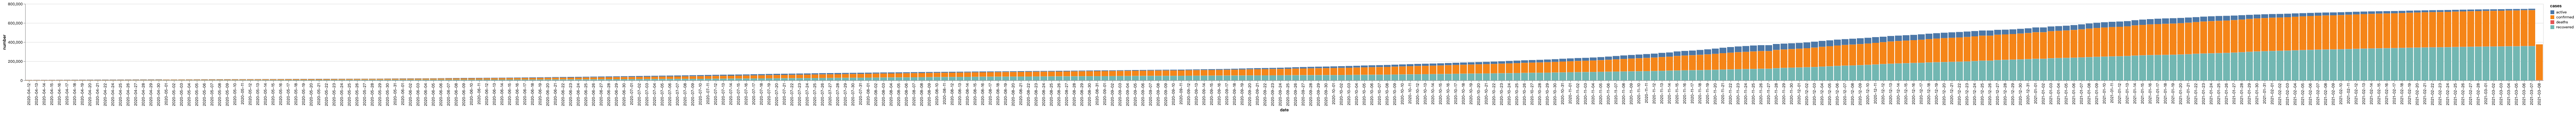




[Database]: covid19
[NL Question]: Visualize the distribution of deaths cases on 2021-03-01 versus states as a bar chart.
[Chart Template]: visualize [c] select [x], [agg(y)] from us_states where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select states , number from us_states where date = '2021-03-01' and cases = 'deaths' group by states
[The Ground Truth VIS Query]: Visualize bar SELECT states , number FROM us_states WHERE date = '2021-03-01' and cases = 'deaths' GROUP BY states
The Predicted VIS:


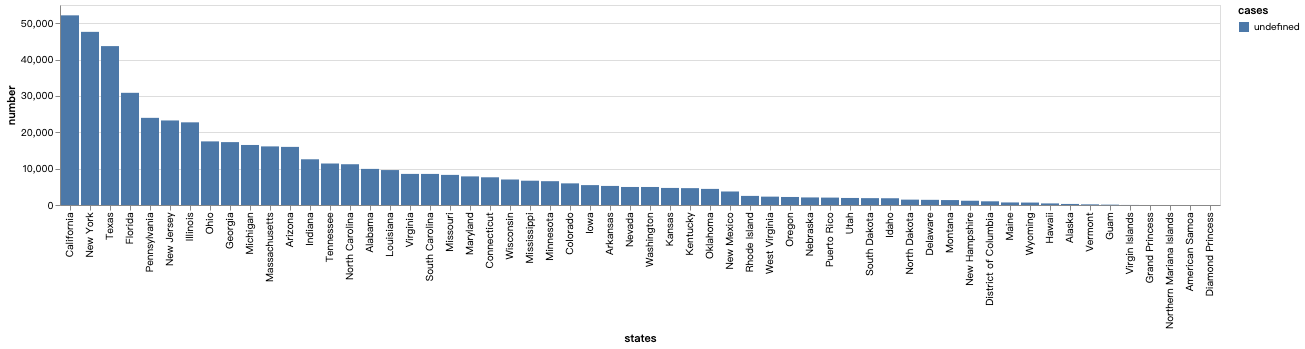




[Database]: covid19
[NL Question]: Create a bar chart showing the top 5 states with the most conﬁrmed cases until 2021-01-01
[Chart Template]: visualize bar select [x], [agg(y)] from us_states where [w] group by [y] bin [x] by [i] order by [y] desc
[Predicted VIS Query]: visualize bar select states , number from us_states where date = '2021-01-01' and cases = 'confirmed' order by number desc limit 5
[The Ground Truth VIS Query]: Visualize bar SELECT states , number FROM us_states WHERE date = '2021-01-01' and cases = 'confirmed' ORDER BY number DESC LIMIT 5
The Predicted VIS:


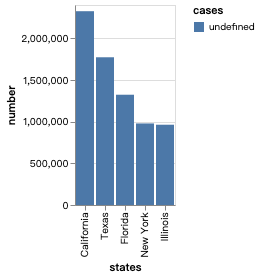




[Database]: covid19
[NL Question]: Show me a pie chart total number across by each case in New York on 2021-02-27
[Chart Template]: visualize pie select [x], [agg(y)] from [d] where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize pie select cases , number from us_states where date = '2021-02-27' and states = 'new york' group by cases
[The Ground Truth VIS Query]: Visualize pie SELECT cases , number FROM us_states WHERE date = '2021-02-27' and states = 'New York' GROUP BY cases
The Predicted VIS:


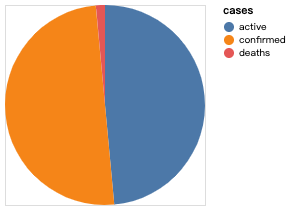




[Database]: covid19
[NL Question]: Show a bar chart about the deaths cases of all states by ranging the date from 2020-04-12 to 2021-03-08
[Chart Template]: visualize [c] select [x], [agg(y)] from us_states where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select date , cases , sum(number) from us_states where date >= '2020-04-12' and date <= '2021-03-08' and cases = 'deaths' group by date
[The Ground Truth VIS Query]: Visualize bar SELECT date , sum(number) FROM us_states WHERE date >= '2020-04-12' and date <= '2021-03-08' and cases = 'deaths' GROUP BY date
The Predicted VIS:


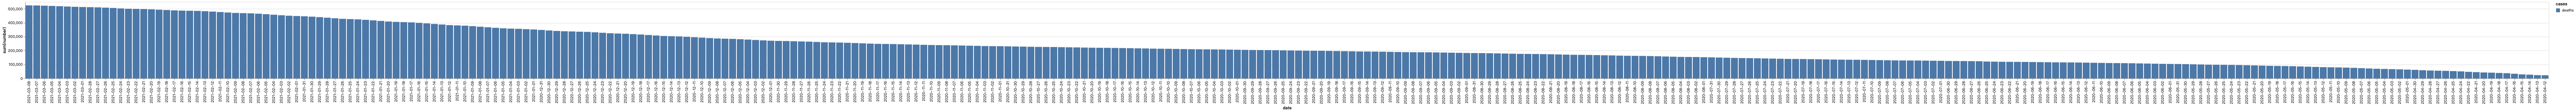




[Database]: covid19
[NL Question]: I want to know how many patients are recovered in each state on 2021-01-01 and display from more to less order
[Chart Template]: visualize [c] select [x], [agg(y)] from us_states where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select states , cases , number from us_states where date = '2021-01-01' group by states order by number desc
[The Ground Truth VIS Query]: Visualize bar SELECT states , number from us_states WHERE cases = 'recovered' and date = '2021-01-01' GROUP BY states ORDER BY number DESC
The Predicted VIS:


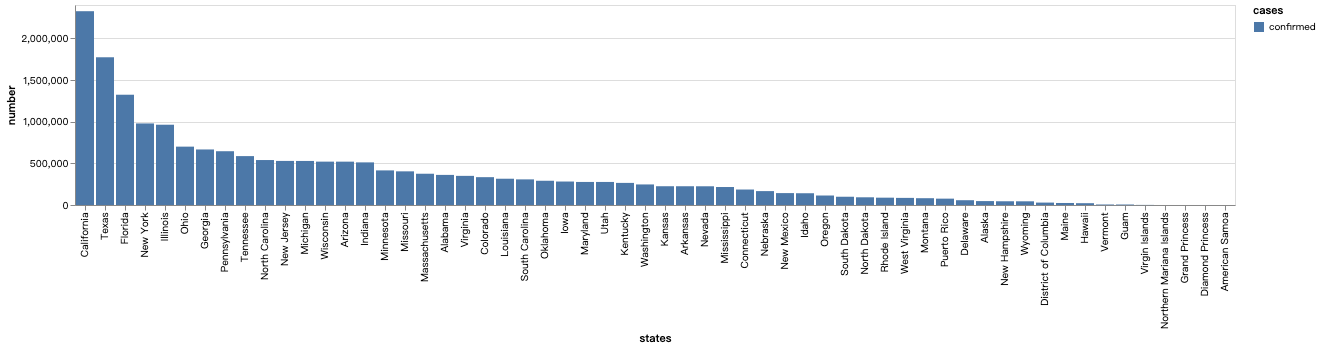




[Database]: covid19
[NL Question]: A line chart showing the confirmed , deaths , and recovered cases of the Texas state
[Chart Template]: visualize [c] select [x], [agg(y)] from us_states where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize line select date , cases , number from us_states where states = 'texas' group by date , cases
[The Ground Truth VIS Query]: Visualize line SELECT date , cases , number from us_states WHERE states = 'Texas' GROUP BY date , cases
The Predicted VIS:


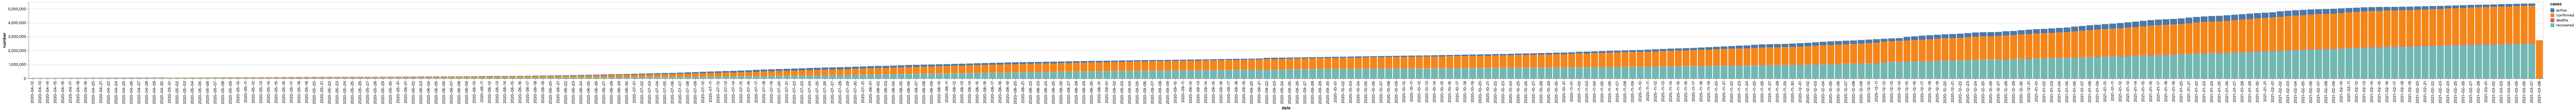




[Database]: covid19
[NL Question]: A line chart about the deaths cases of all states by ranging the date from 2020-04-12 to 2021-03-08
[Chart Template]: visualize line select [x], [agg(y)] from [d] where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize line select date , sum(number) from us_states where date >= '2020-04-12' and date <= '2021-03-08' and cases = 'deaths' group by date
[The Ground Truth VIS Query]: Visualize line SELECT date , sum(number) FROM us_states WHERE date >= '2020-04-12' and date <= '2021-03-08' and cases = 'deaths' GROUP BY date
The Predicted VIS:


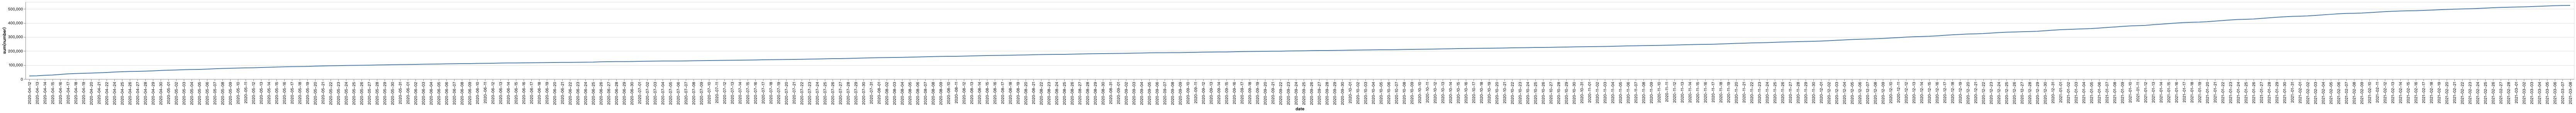




[Database]: covid19
[NL Question]: A line chart showing the confirmed , deaths , and recovered cases of the Texas state
[Chart Template]: visualize line select [x], [agg(y)] from [d] where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize line select date , cases , number from us_states where states = 'texas' group by date , cases
[The Ground Truth VIS Query]: Visualize line SELECT date , cases , number from us_states WHERE states = 'Texas' GROUP BY date , cases
The Predicted VIS:


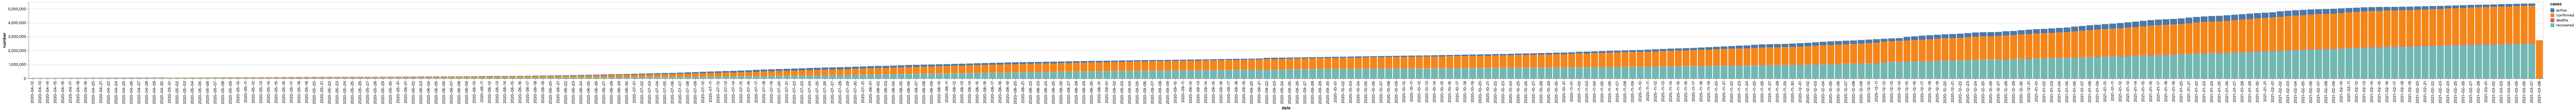




[Database]: covid19
[NL Question]: Plot a bar chart for the number of recovered people on 2021-02-27 in each state
[Chart Template]: visualize bar select [x], [agg(y)] from [d] where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select states , number from us_states where date = '2021-02-27' and cases = 'recovered' group by states
[The Ground Truth VIS Query]: Visualize bar SELECT states , number FROM us_states WHERE date = '2021-02-27' and cases = 'recovered' GROUP BY states
The Predicted VIS:


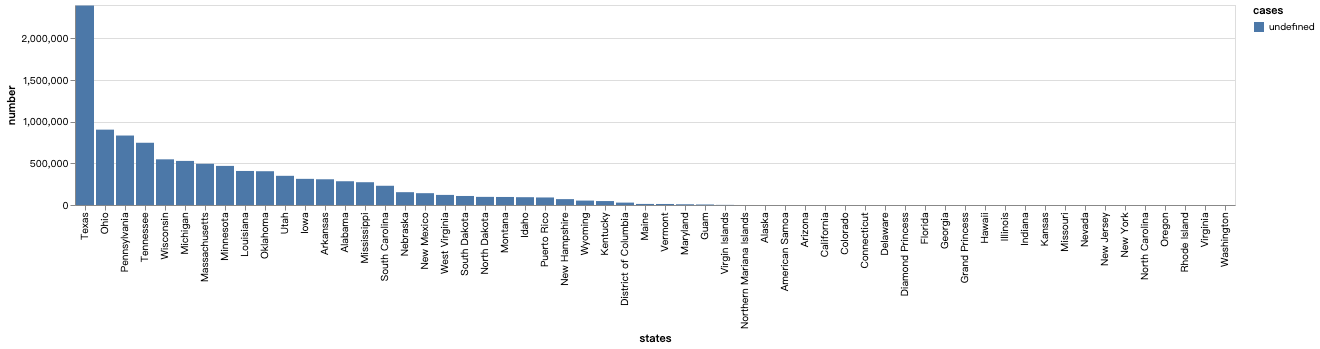




[Database]: covid19
[NL Question]: Show me the trend about the total number of different cases in Utah state
[Chart Template]: visualize [c] select [x], [agg(y)] from us_states where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize line select date , cases , number from us_states where states = 'utah' group by date , cases
[The Ground Truth VIS Query]: Visualize line SELECT date , cases , number from us_states WHERE states = 'Utah' GROUP BY date , cases
The Predicted VIS:


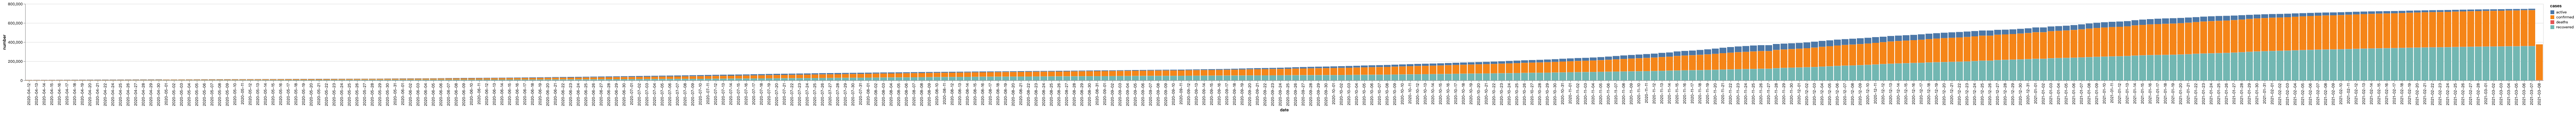




[Database]: covid19
[NL Question]: Create a line chart for the total conﬁrmed of all states across reported date and sort X-axis in asc
[Chart Template]: visualize line select [x], [agg(y)] from us_states where [w] group by [x] bin [x] by [i] order by [x] asc
[Predicted VIS Query]: visualize line select date , sum(number) from us_states where cases = 'confirmed' group by date order by date asc
[The Ground Truth VIS Query]: Visualize line SELECT date , sum(number) from us_states WHERE cases = 'confirmed' GROUP BY date ORDER BY date ASC
The Predicted VIS:


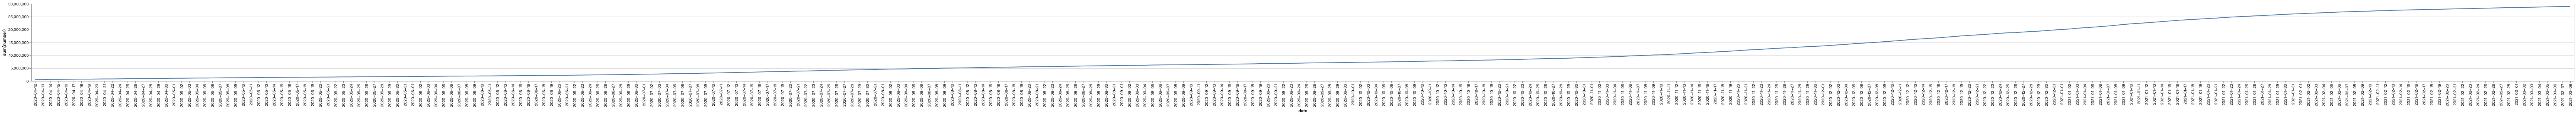




[Database]: covid19
[NL Question]: Visualize the distribution of deaths cases on 2021-03-01 versus states as a bar chart.
[Chart Template]: visualize bar select [x], [agg(y)] from [d] where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select states , number from us_states where date = '2021-03-01' and cases = 'deaths' group by states
[The Ground Truth VIS Query]: Visualize bar SELECT states , number FROM us_states WHERE date = '2021-03-01' and cases = 'deaths' GROUP BY states
The Predicted VIS:


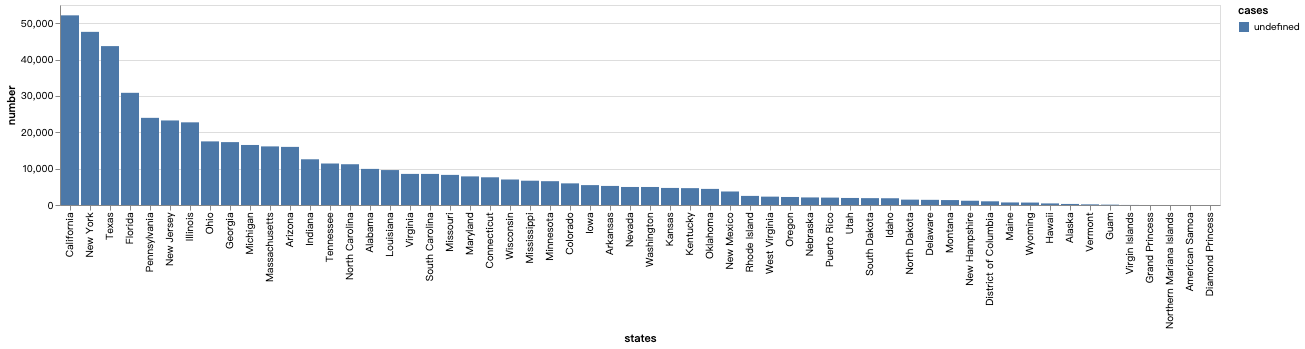




[Database]: covid19
[NL Question]: Show me the trend of total conﬁrmed cases in covid 19 by each date of all states in the US
[Chart Template]: visualize line select [x], [agg(y)] from [d] where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize line select date , cases , sum(number) from us_states where cases = 'confirmed' group by date
[The Ground Truth VIS Query]: Visualize line SELECT date , sum(number) FROM us_states WHERE cases = 'confirmed' GROUP BY date
The Predicted VIS:


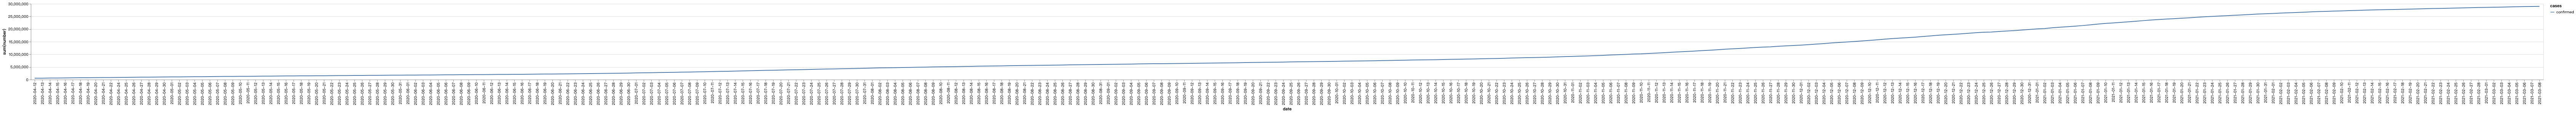




[Database]: covid19
[NL Question]: top 5 states with the most conﬁrmed cases until 2021-03-08
[Chart Template]: visualize [c] select [x], [agg(y)] from us_states where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select states , number from us_states where date = '2021-03-08' and cases = 'confirmed' order by number desc limit 5
[The Ground Truth VIS Query]: Visualize bar SELECT states , number FROM us_states WHERE date = '2021-03-08' and cases = 'confirmed' ORDER BY number DESC LIMIT 5
The Predicted VIS:


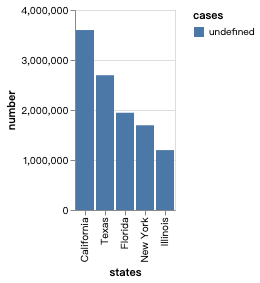




[Database]: covid19
[NL Question]: Create a bar chart showing the top 5 states with the most conﬁrmed cases until 2021-03-08
[Chart Template]: visualize [c] select [x], [agg(y)] from us_states where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select states , number from us_states where date = '2021-03-08' and cases = 'confirmed' order by number desc limit 5
[The Ground Truth VIS Query]: Visualize bar SELECT states , number FROM us_states WHERE date = '2021-03-08' and cases = 'confirmed' ORDER BY number DESC LIMIT 5
The Predicted VIS:


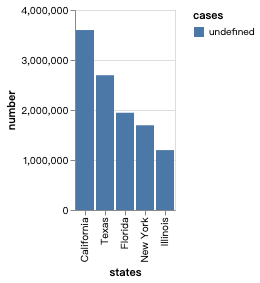




[Database]: covid19
[NL Question]: show me the total number by case in Massachusetts on 2021-02-27 as a pie chart
[Chart Template]: visualize pie select [x], [agg(y)] from [d] where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize pie select cases , number from us_states where date = '2021-02-27' and states = 'massachusetts' group by cases
[The Ground Truth VIS Query]: Visualize pie SELECT cases , number FROM us_states WHERE date = '2021-02-27' and states = 'Massachusetts' GROUP BY cases
The Predicted VIS:


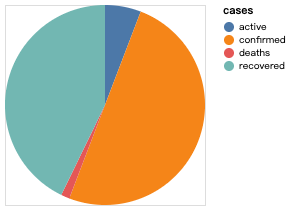




[Database]: covid19
[NL Question]: I want to know how many patients recovered in each state on 2021-02-27
[Chart Template]: visualize bar select [x], [agg(y)] from [d] where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select states , number from us_states where date = '2021-02-27' and cases = 'recovered' group by states
[The Ground Truth VIS Query]: Visualize bar SELECT states , number FROM us_states WHERE date = '2021-02-27' and cases = 'recovered' GROUP BY states
The Predicted VIS:


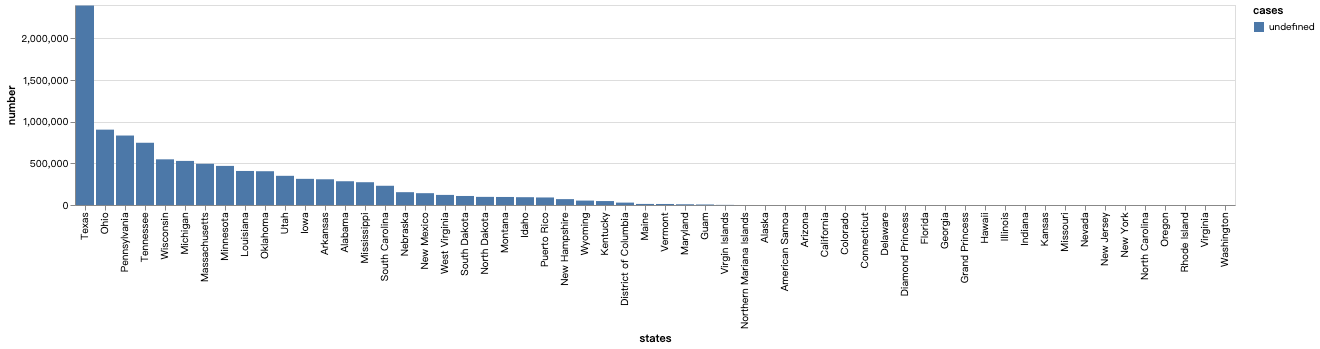




[Database]: covid19
[NL Question]: How many people died in the covid 19 in each state on 2021-03-08 ? Show me a bar chart .
[Chart Template]: visualize bar select [x], [agg(y)] from [d] where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select states , states from us_states where date = '2021-03-08' and cases = 'deaths' group by states
[The Ground Truth VIS Query]: Visualize bar SELECT states , number FROM us_states WHERE date = '2021-03-08' and cases = 'deaths' GROUP BY states

[Database]: covid19
[NL Question]: A line chart about the deaths cases of all states by ranging the date from 2020-04-12 to 2021-03-08
[Chart Template]: visualize [c] select [x], [agg(y)] from us_states where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize line select date , sum(number) from us_states where date >= '2020-04-12' and date <= '2021-03-08' and cases = 'deaths' group by date
[The Ground Truth VIS Query]: Visualize line

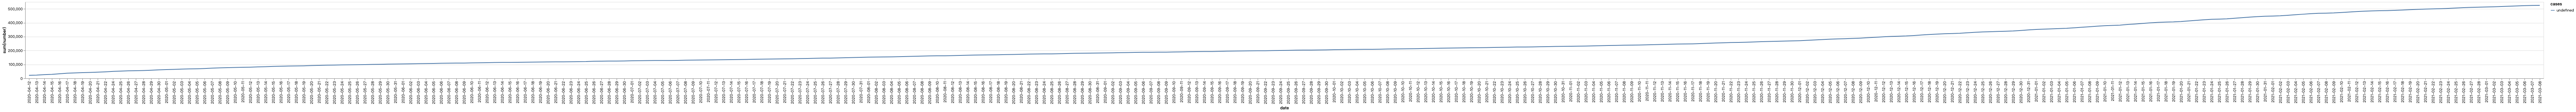




[Database]: covid19
[NL Question]: I want to know the proportion of total number by each case in Massachusetts on 2021-02-27
[Chart Template]: visualize [c] select [x], [agg(y)] from us_states where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize pie select cases , number from us_states where date = '2021-02-27' and states = 'massachusetts' group by cases
[The Ground Truth VIS Query]: Visualize pie SELECT cases , number FROM us_states WHERE date = '2021-02-27' and states = 'Massachusetts' GROUP BY cases
The Predicted VIS:


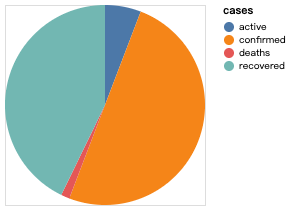




[Database]: covid19
[NL Question]: sort the total conﬁrmed cases in desc order by each date of all states in the US
[Chart Template]: visualize bar select [x], [agg(y)] from us_states where [w] group by [y] bin [x] by [i] order by [y] desc
[Predicted VIS Query]: visualize bar select date , cases , sum(number) from us_states where cases = 'confirmed' group by date order by sum(number) desc
[The Ground Truth VIS Query]: Visualize bar SELECT date , sum(number) from us_states WHERE cases = 'confirmed' GROUP BY date ORDER BY sum(number) DESC
The Predicted VIS:


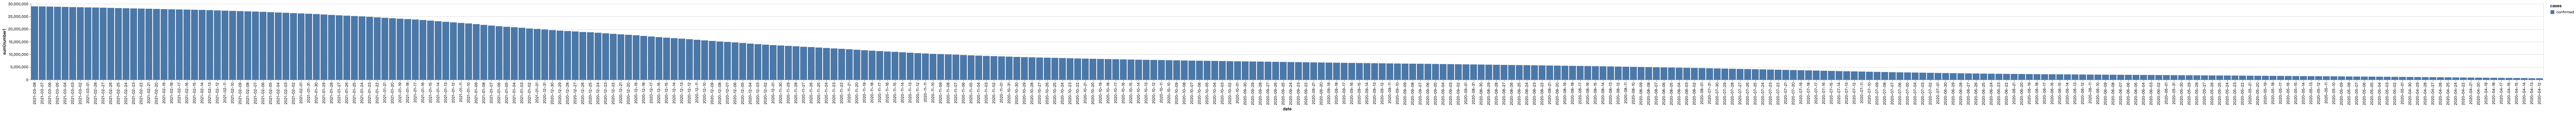




[Database]: covid19
[NL Question]: Create a bar chart showing the top 5 states with the most recovered cases until 2021-01-01
[Chart Template]: visualize [c] select [x], [agg(y)] from us_states where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select states , cases , number from us_states where date = '2021-01-01' and states = '2021-01-01' and states != 'nyy' group by states order by number desc limit 5
[The Ground Truth VIS Query]: Visualize bar SELECT states , number FROM us_states WHERE date = '2021-01-01' and cases = 'recovered' ORDER BY number DESC LIMIT 5
The Predicted VIS:


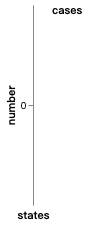




[Database]: covid19
[NL Question]: Show me the trend of total conﬁrmed cases in covid 19 by each date of all states in the US
[Chart Template]: visualize [c] select [x], [agg(y)] from us_states where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize line select date , cases , sum(number) from us_states where cases = 'confirmed' group by date
[The Ground Truth VIS Query]: Visualize line SELECT date , sum(number) FROM us_states WHERE cases = 'confirmed' GROUP BY date
The Predicted VIS:


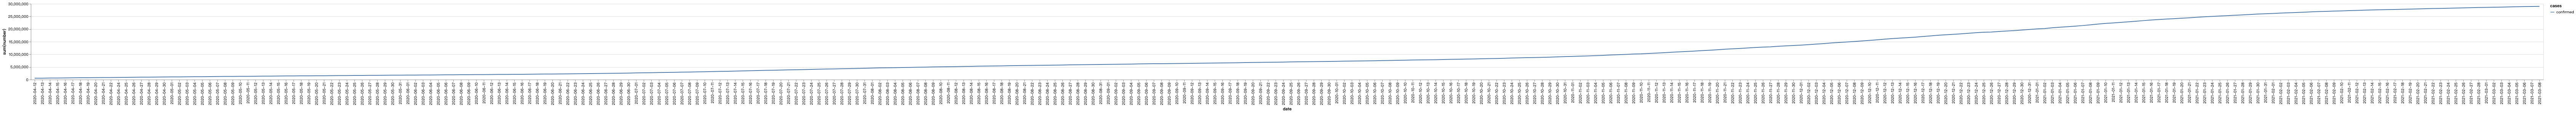




[Database]: covid19
[NL Question]: I want to know how many patients died in each state on 2021-02-27
[Chart Template]: visualize [c] select [x], [agg(y)] from us_states where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select states , states from us_states where date = '2021-02-27' and cases = 'deaths' group by states
[The Ground Truth VIS Query]: Visualize bar SELECT states , number FROM us_states WHERE date = '2021-02-27' and cases = 'deaths' GROUP BY states

[Database]: covid19
[NL Question]: sort the total conﬁrmed cases in desc order by each date of all states in the US
[Chart Template]: visualize [c] select [x], [agg(y)] from us_states where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select date , cases , sum(number) from us_states where cases = 'confirmed' group by date order by sum(number) desc
[The Ground Truth VIS Query]: Visualize bar SELECT date , sum(number) from us_states WHERE cas

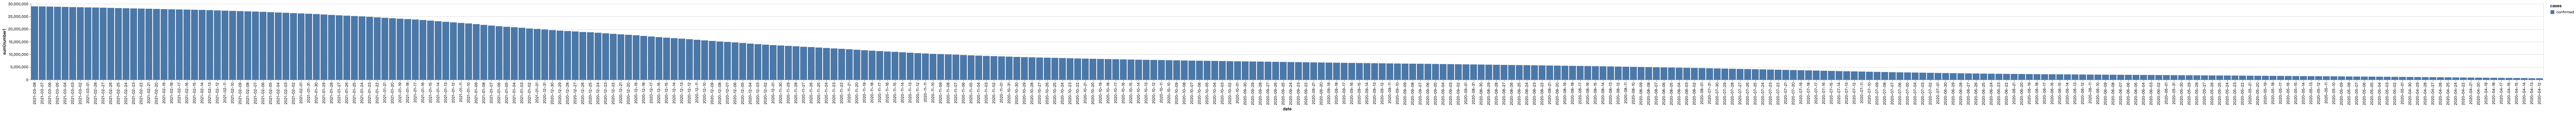




[Database]: covid19
[NL Question]: show me the total number by case in Massachusetts on 2021-02-27 as a bar chart
[Chart Template]: visualize [c] select [x], [agg(y)] from us_states where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select cases , number from us_states where date = '2021-02-27' and states = 'massachusetts' group by cases
[The Ground Truth VIS Query]: Visualize bar SELECT cases , number FROM us_states WHERE date = '2021-02-27' and states = 'Massachusetts' GROUP BY cases
The Predicted VIS:


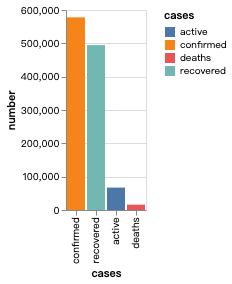




[Database]: covid19
[NL Question]: A line chart showing the confirmed , deaths , and recovered cases of the Utah state
[Chart Template]: visualize [c] select [x], [agg(y)] from us_states where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize line select date , cases , number from us_states where states = 'utah' group by date , cases
[The Ground Truth VIS Query]: Visualize line SELECT date , cases , number from us_states WHERE states = 'Utah' GROUP BY date , cases
The Predicted VIS:


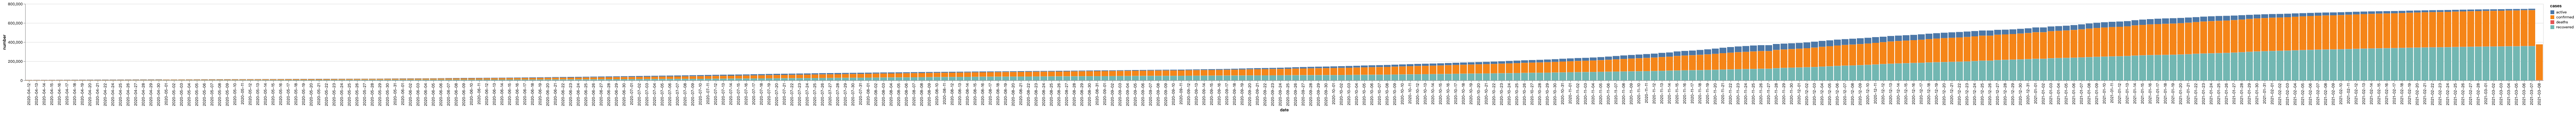




[Database]: covid19
[NL Question]: I want to know how many patients died in each state on 2021-02-27
[Chart Template]: visualize bar select [x], [agg(y)] from [d] where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select states , number from us_states where date = '2021-02-27' and cases = 'deaths' group by states
[The Ground Truth VIS Query]: Visualize bar SELECT states , number FROM us_states WHERE date = '2021-02-27' and cases = 'deaths' GROUP BY states
The Predicted VIS:


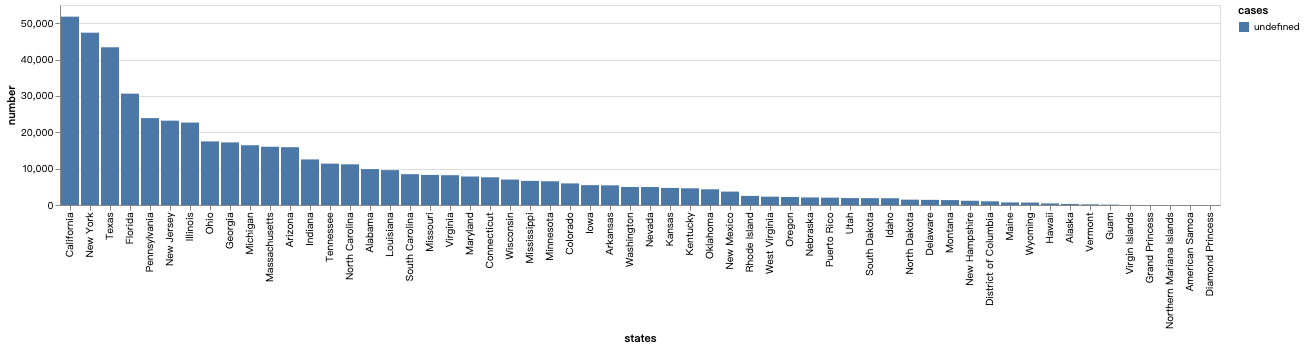




[Database]: covid19
[NL Question]: plot confirmed , deaths , and recovered cases of the Texas state as a line chart
[Chart Template]: visualize line select [x], [agg(y)] from [d] where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize line select date , cases , number from us_states where states = 'texas' group by date , cases
[The Ground Truth VIS Query]: Visualize line SELECT date , cases , number FROM us_states WHERE states = 'Texas' GROUP BY date , cases
The Predicted VIS:


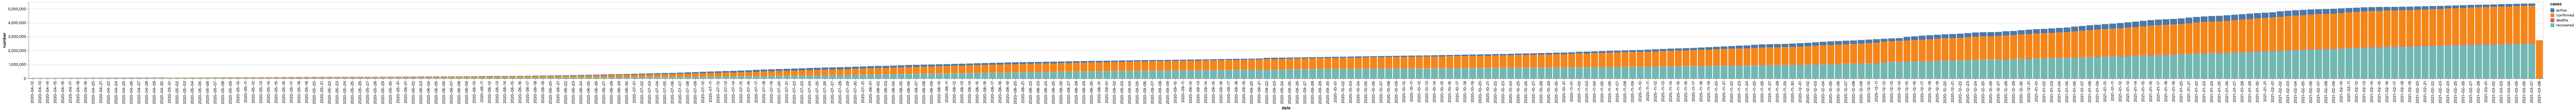




[Database]: covid19
[NL Question]: Show me the trend about the total number of different cases in Utah state
[Chart Template]: visualize line select [x], [agg(y)] from [d] where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize line select date , cases , number from us_states where states = 'utah' group by date , cases
[The Ground Truth VIS Query]: Visualize line SELECT date , cases , number from us_states WHERE states = 'Utah' GROUP BY date , cases
The Predicted VIS:


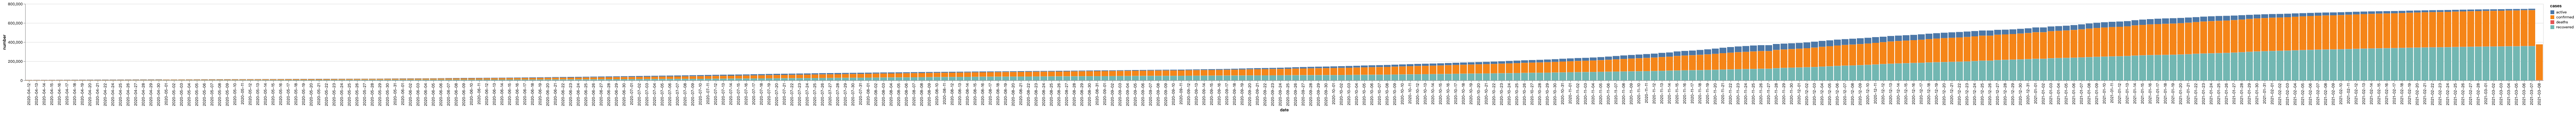




[Database]: covid19
[NL Question]: for 2021-01-01 , I want to know the total number by different cases for each state with a stacked bar chart
[Chart Template]: visualize [c] select [x], [agg(y)] from us_states where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select states , cases , sum(number) from us_states where date = '2021-01-01' group by states , cases
[The Ground Truth VIS Query]: Visualize bar SELECT states , cases , sum(number) FROM us_states WHERE date = '2021-01-01' GROUP BY states , cases
The Predicted VIS:


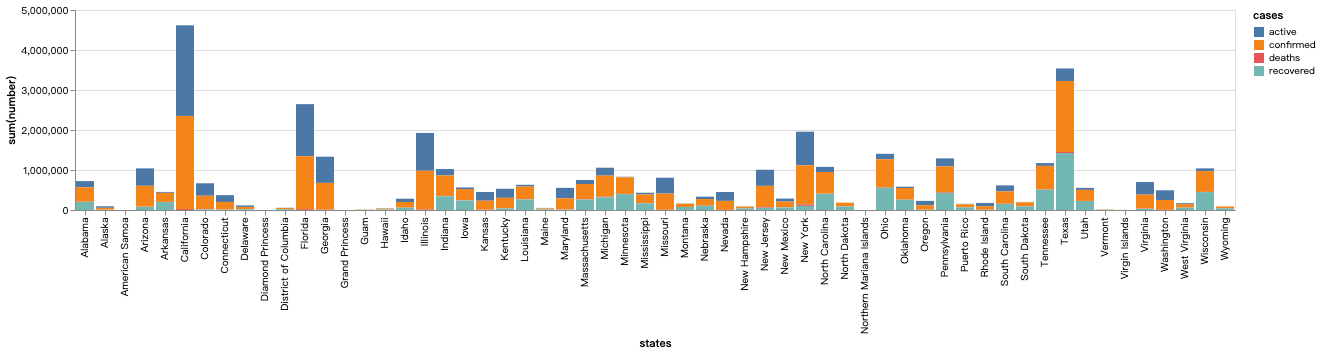




[Database]: covid19
[NL Question]: top 5 states with the most conﬁrmed cases until 2021-03-08
[Chart Template]: visualize bar select [x], [agg(y)] from us_states where [w] group by [y] bin [x] by [i] order by [y] desc
[Predicted VIS Query]: visualize bar select states , number from us_states where date = '2021-03-08' and cases = 'confirmed' order by number desc limit 5
[The Ground Truth VIS Query]: Visualize bar SELECT states , number FROM us_states WHERE date = '2021-03-08' and cases = 'confirmed' ORDER BY number DESC LIMIT 5
The Predicted VIS:


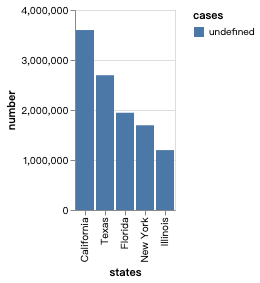




[Database]: covid19
[NL Question]: show me the total number by case in Massachusetts on 2021-02-27 as a bar chart
[Chart Template]: visualize bar select [x], [agg(y)] from [d] where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select cases , number from us_states where date = '2021-02-27' and states = 'massachusetts' group by cases
[The Ground Truth VIS Query]: Visualize bar SELECT cases , number FROM us_states WHERE date = '2021-02-27' and states = 'Massachusetts' GROUP BY cases
The Predicted VIS:


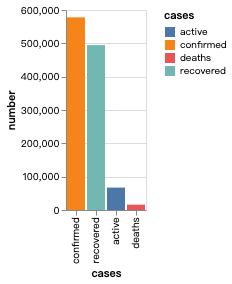




[Database]: covid19
[NL Question]: Create a bar chart showing the top 5 states with the most conﬁrmed cases until 2021-01-01
[Chart Template]: visualize [c] select [x], [agg(y)] from us_states where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select states , number from us_states where date = '2021-01-01' and cases = 'confirmed' order by number desc limit 5
[The Ground Truth VIS Query]: Visualize bar SELECT states , number FROM us_states WHERE date = '2021-01-01' and cases = 'confirmed' ORDER BY number DESC LIMIT 5
The Predicted VIS:


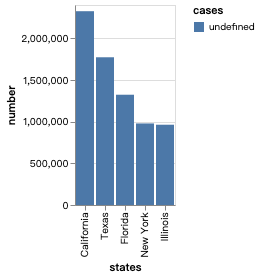




[Database]: covid19
[NL Question]: Create a line chart for the total conﬁrmed of all states across reported date and sort X-axis in asc
[Chart Template]: visualize [c] select [x], [agg(y)] from us_states where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize line select date , sum(number) from us_states where cases = 'confirmed' group by date order by date asc
[The Ground Truth VIS Query]: Visualize line SELECT date , sum(number) from us_states WHERE cases = 'confirmed' GROUP BY date ORDER BY date ASC
The Predicted VIS:


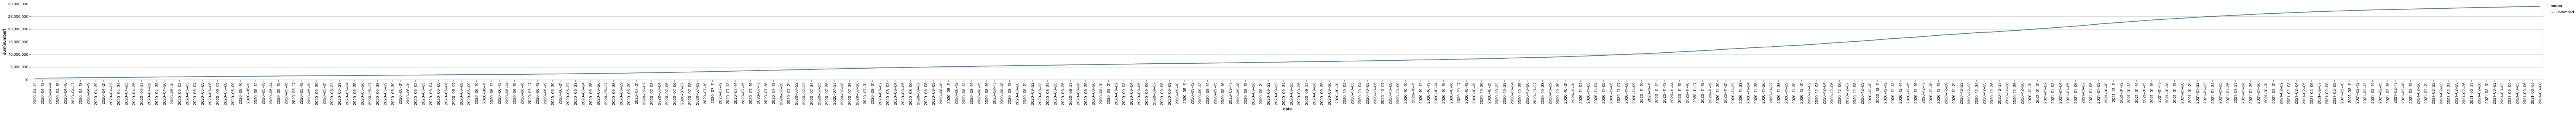




[Database]: covid19
[NL Question]: Create a bar chart showing the top 5 states with the most conﬁrmed cases until 2021-03-08
[Chart Template]: visualize bar select [x], [agg(y)] from us_states where [w] group by [y] bin [x] by [i] order by [y] desc
[Predicted VIS Query]: visualize bar select states , number from us_states where date = '2021-03-08' and cases = 'confirmed' order by number desc limit 5
[The Ground Truth VIS Query]: Visualize bar SELECT states , number FROM us_states WHERE date = '2021-03-08' and cases = 'confirmed' ORDER BY number DESC LIMIT 5
The Predicted VIS:


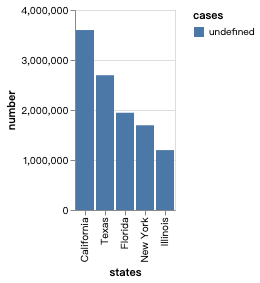




[Database]: covid19
[NL Question]: Create a line chart for the total conﬁrmed of all states across reported date
[Chart Template]: visualize line select [x], [agg(y)] from [d] where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize line select date , sum(number) from us_states where cases = 'confirmed' group by date
[The Ground Truth VIS Query]: Visualize line SELECT date , sum(number) FROM us_states WHERE cases = 'confirmed' GROUP BY date
The Predicted VIS:


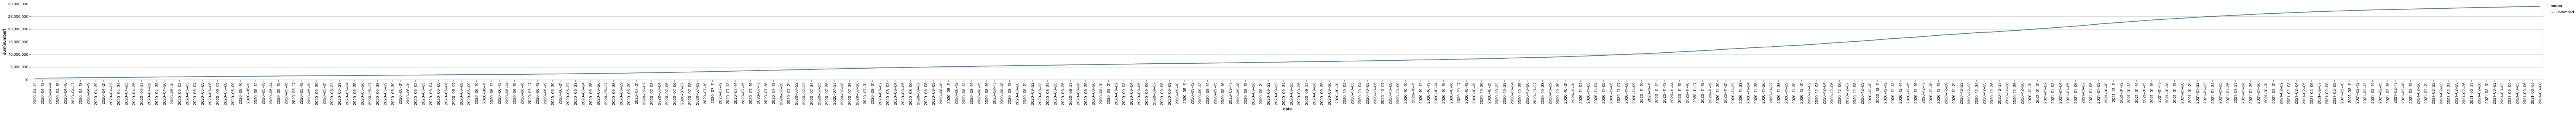




[Database]: covid19
[NL Question]: show me the total number by case in Massachusetts on 2021-02-27 as a pie chart
[Chart Template]: visualize [c] select [x], [agg(y)] from us_states where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize pie select cases , number from us_states where date = '2021-02-27' and states = 'massachusetts' group by cases
[The Ground Truth VIS Query]: Visualize pie SELECT cases , number FROM us_states WHERE date = '2021-02-27' and states = 'Massachusetts' GROUP BY cases
The Predicted VIS:


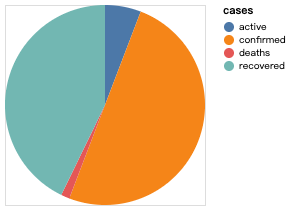




[Database]: covid19
[NL Question]: I want to know how many patients recovered in each state on 2021-02-27
[Chart Template]: visualize [c] select [x], [agg(y)] from us_states where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select states , number from us_states where date = '2021-02-27' and cases = 'recovered' group by states
[The Ground Truth VIS Query]: Visualize bar SELECT states , number FROM us_states WHERE date = '2021-02-27' and cases = 'recovered' GROUP BY states
The Predicted VIS:


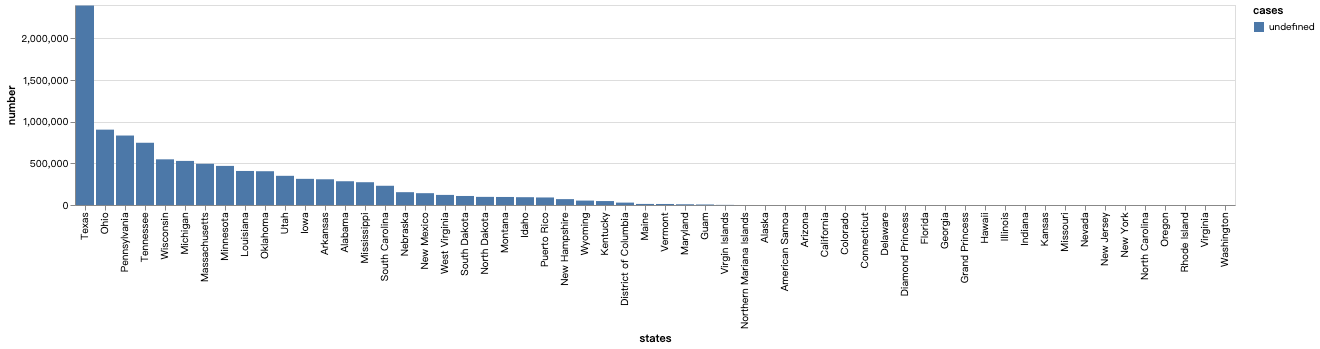




[Database]: covid19
[NL Question]: Create a line chart for the total conﬁrmed of all states across reported date
[Chart Template]: visualize [c] select [x], [agg(y)] from us_states where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize line select date , sum(number) from us_states where cases = 'confirmed' group by date
[The Ground Truth VIS Query]: Visualize line SELECT date , sum(number) FROM us_states WHERE cases = 'confirmed' GROUP BY date
The Predicted VIS:


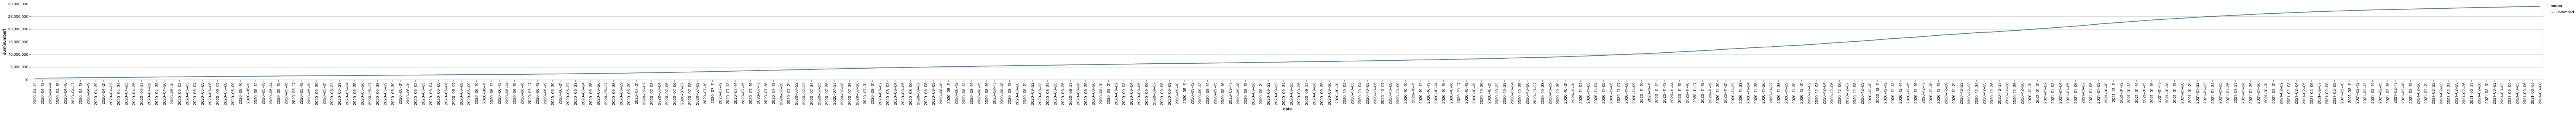




[Database]: covid19
[NL Question]: plot confirmed , deaths , and recovered cases of the Texas state as a line chart
[Chart Template]: visualize [c] select [x], [agg(y)] from us_states where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize line select date , cases , number from us_states where states = 'texas' group by date , cases
[The Ground Truth VIS Query]: Visualize line SELECT date , cases , number FROM us_states WHERE states = 'Texas' GROUP BY date , cases
The Predicted VIS:


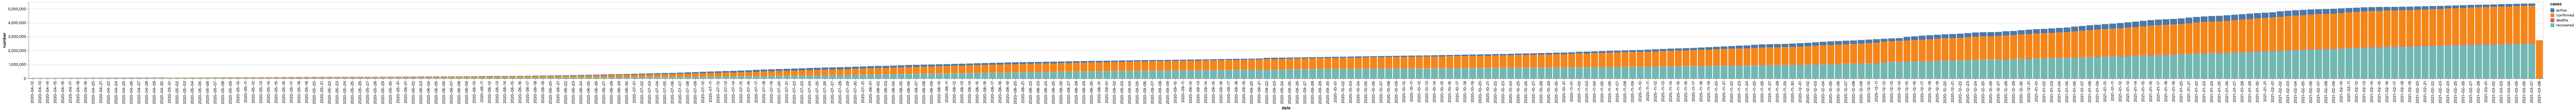




[Database]: covid19
[NL Question]: I want to know how many patients are recovered in each state on 2021-01-01 and display from more to less order
[Chart Template]: visualize bar select [x], [agg(y)] from us_states where [w] group by [y] bin [x] by [i] order by [y] desc
[Predicted VIS Query]: visualize bar select states , cases , number from us_states where date = '2021-01-01' group by states order by number desc
[The Ground Truth VIS Query]: Visualize bar SELECT states , number from us_states WHERE cases = 'recovered' and date = '2021-01-01' GROUP BY states ORDER BY number DESC
The Predicted VIS:


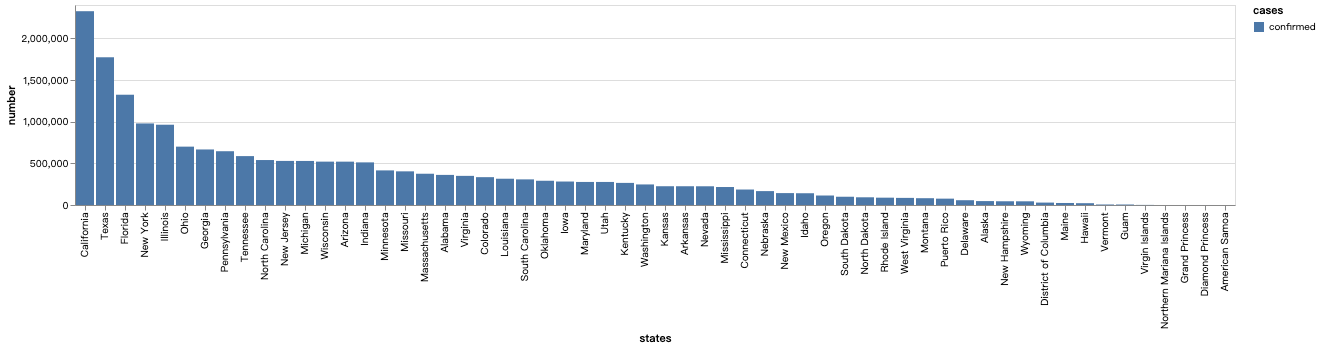




[Database]: covid19
[NL Question]: Plot a bar chart for the number of died people on 2021-01-01 in each state , and sort Y-axis in desc order
[Chart Template]: visualize [c] select [x], [agg(y)] from us_states where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select states , number from us_states where cases = 'deaths' and date = '2021-01-01' group by states order by number desc
[The Ground Truth VIS Query]: Visualize bar SELECT states , number from us_states WHERE cases = 'deaths' and date = '2021-01-01' GROUP BY states ORDER BY number DESC
The Predicted VIS:


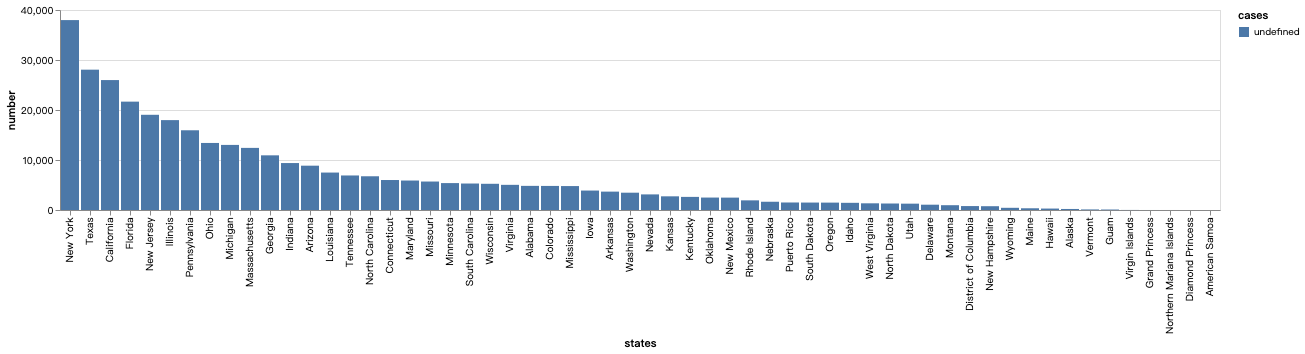




[Database]: covid19
[NL Question]: Show me a pie chart total number across by each case in New York on 2021-02-27
[Chart Template]: visualize [c] select [x], [agg(y)] from us_states where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize pie select cases , number from us_states where date = '2021-02-27' and states = 'new york' group by cases
[The Ground Truth VIS Query]: Visualize pie SELECT cases , number FROM us_states WHERE date = '2021-02-27' and states = 'New York' GROUP BY cases
The Predicted VIS:


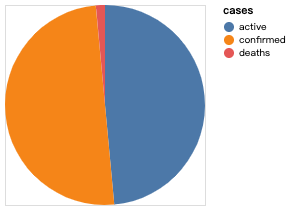




[Database]: covid19
[NL Question]: How many people died in the covid 19 in each state on 2021-03-08 ? Show me a bar chart .
[Chart Template]: visualize [c] select [x], [agg(y)] from us_states where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select states , states from us_states where date = '2021-03-08' and cases = 'deaths' group by states
[The Ground Truth VIS Query]: Visualize bar SELECT states , number FROM us_states WHERE date = '2021-03-08' and cases = 'deaths' GROUP BY states

[Database]: covid19
[NL Question]: Plot a bar chart for the number of recovered people on 2021-01-01 in each state , and sort Y-axis in desc order
[Chart Template]: visualize bar select [x], [agg(y)] from us_states where [w] group by [y] bin [x] by [i] order by [y] desc
[Predicted VIS Query]: visualize bar select states , number from us_states where cases = 'recovered' and date = '2021-01-01' group by states order by number desc
[The Ground Truth VIS Query]: V

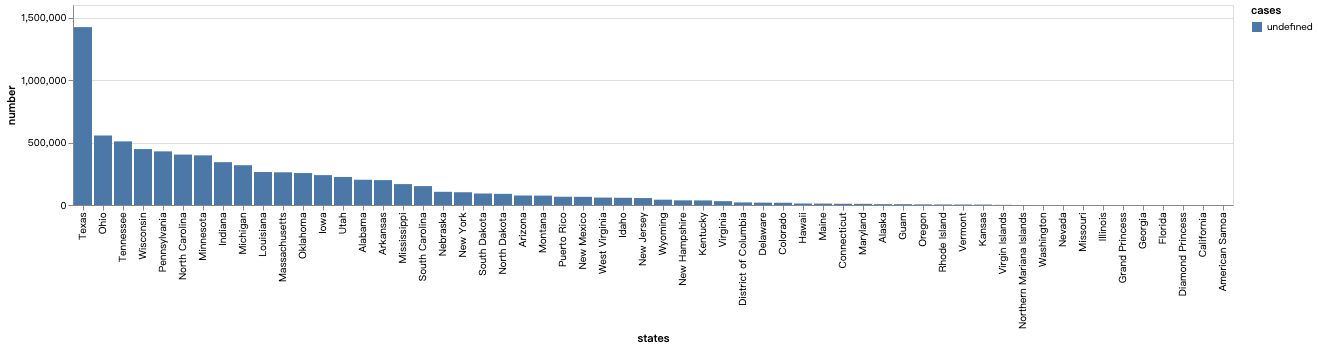




[Database]: covid19
[NL Question]: I want to know the proportion of total number by each case in Massachusetts on 2021-02-27
[Chart Template]: visualize pie select [x], [agg(y)] from [d] where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize pie select cases , number from us_states where date = '2021-02-27' and states = 'massachusetts' group by cases
[The Ground Truth VIS Query]: Visualize pie SELECT cases , number FROM us_states WHERE date = '2021-02-27' and states = 'Massachusetts' GROUP BY cases
The Predicted VIS:


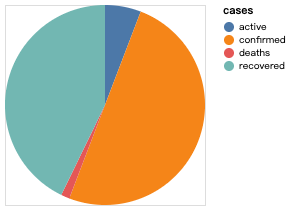




[Database]: covid19
[NL Question]: draw a stacked bar to show the total number by different cases for each state on 2021-01-01
[Chart Template]: visualize bar select [x], [agg(y)] from [d] where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select states , cases , sum(number) from us_states where date = '2021-01-01' group by states , cases
[The Ground Truth VIS Query]: Visualize bar SELECT states , cases , sum(number) FROM us_states WHERE date = '2021-01-01' GROUP BY states , cases
The Predicted VIS:


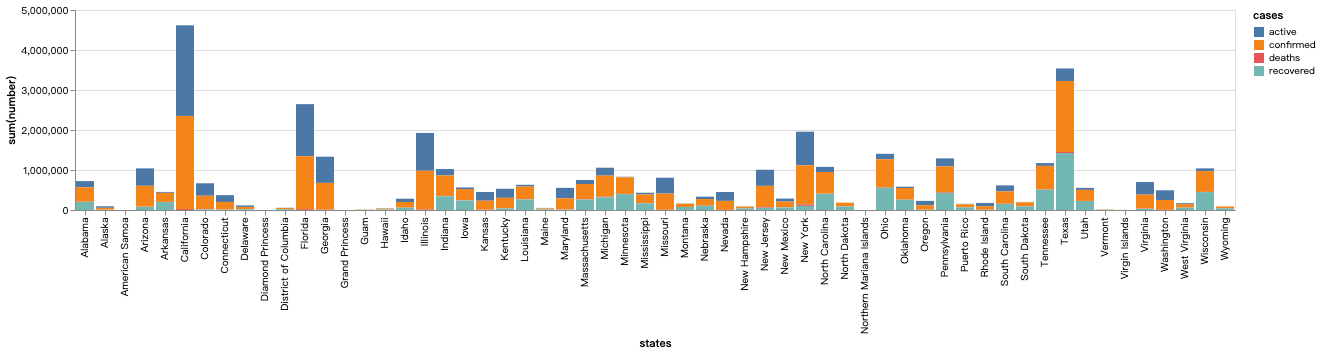




[Database]: covid19
[NL Question]: Plot a bar chart for the number of recovered people on 2021-02-27 in each state
[Chart Template]: visualize [c] select [x], [agg(y)] from us_states where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select states , number from us_states where date = '2021-02-27' and cases = 'recovered' group by states
[The Ground Truth VIS Query]: Visualize bar SELECT states , number FROM us_states WHERE date = '2021-02-27' and cases = 'recovered' GROUP BY states
The Predicted VIS:


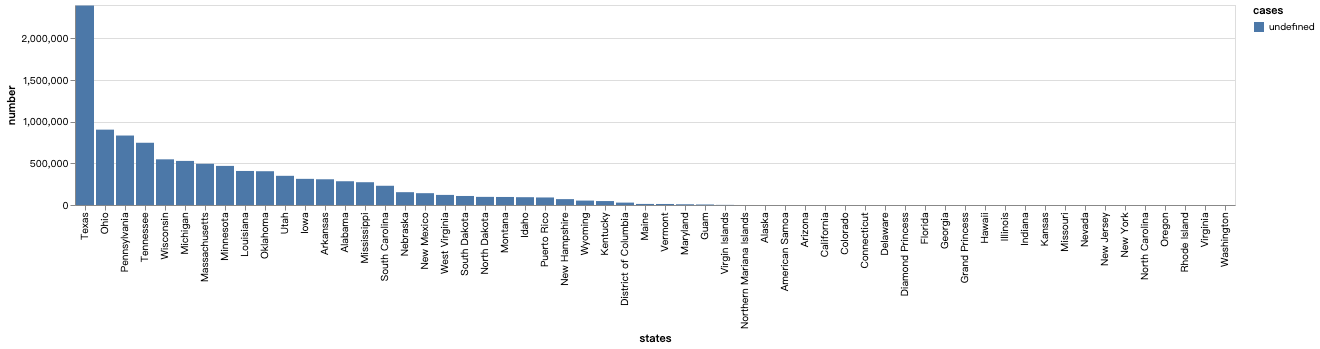

In [13]:
create_vis = VisRendering()
for index, row in covid19_df.iterrows():
    try:
        gold_query = row['labels'].lower()

        src = row['source'].lower()

        tok_types = row['token_types']

        translation, attention, enc_attention = translate_sentence_with_guidance(
            row['db_id'], gold_query.split(' ')[gold_query.split(' ').index('from') + 1],
            src, SRC, TRG, TOK_TYPES, tok_types, SRC, model, db_tables_columns, device, my_max_length
        )

        pred_query = ' '.join(translation).replace(' <eos>', '').lower()
        old_pred_query = pred_query

        if '[c]' not in src:
            # with template
            pred_query = postprocessing(gold_query, pred_query, True, src)

            print('=========================================================\n')
            print('[Database]:', row['db_id'])
            print('[NL Question]:', row['question'])
            print('[Chart Template]:', row['query_template'])
            print('[Predicted VIS Query]:',' '.join(pred_query.replace('"', "'").split()))
            print('[The Ground Truth VIS Query]:', row['query'])

            vis_query = create_vis.parse_output_query(
                './dataset/database/',
                row['db_id'],
                'us_states',
                ' '.join(pred_query.replace('"', "'").split())
            )

            data4vis = create_vis.query_sqlite3(
                './dataset/database/',
                row['db_id'],
                vis_query['data_part']['sql_part']
            )

            print('The Predicted VIS:')
            create_vis.render_vis(data4vis, vis_query)
            print('\n')

        if '[c]' in src:
            # without template
            pred_query = postprocessing(gold_query, pred_query, False, src)

            print('=========================================================\n')
            print('[Database]:', row['db_id'])
            print('[NL Question]:', row['question'])
            print('[Chart Template]:', row['query_template'])
            print('[Predicted VIS Query]:',' '.join(pred_query.replace('"', "'").split()))
            print('[The Ground Truth VIS Query]:', row['query'])

            vis_query = create_vis.parse_output_query(
                './dataset/database/',
                row['db_id'],
                'us_states',
                ' '.join(pred_query.replace('"', "'").split())
            )

            data4vis = create_vis.query_sqlite3(
                './dataset/database/',
                row['db_id'],
                vis_query['data_part']['sql_part']
            )

            print('The Predicted VIS:')
            create_vis.render_vis(data4vis, vis_query)
            print('\n')
    except:
        pass
            


    

## testing and rendering the result using vega-lite


[Database]: cre_Doc_Tracking_DB
[NL Question]: What is the code of each location and the number of documents in that location . Visualize by pie chart .
[Chart Template]: visualize pie select [x], [agg(y)] from [d] where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize pie select location_code , count(*) from document_locations group by location_code
[The Ground Truth VIS Query]: Visualize PIE SELECT Location_Code , count(*) FROM Document_locations GROUP BY location_code
The Predicted VIS:


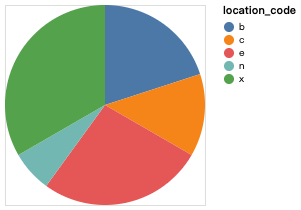




[Database]: document_management
[NL Question]: What are the different role codes for users , and how many users have each .
[Chart Template]: visualize pie select [x], [agg(y)] from [d] where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize pie select role_code , count(*) from users group by role_code
[The Ground Truth VIS Query]: Visualize PIE SELECT role_code , count(*) FROM users GROUP BY role_code
The Predicted VIS:


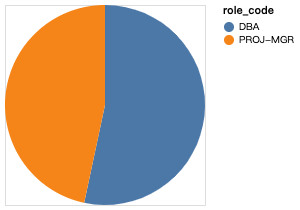




[Database]: cre_Theme_park
[NL Question]: Show different ways to get to attractions and the number of attractions that can be accessed in the corresponding way in a bar chart , and show by the bars from high to low .
[Chart Template]: visualize [c] select [x], [agg(y)] from tourist_attractions where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select how_to_get_there , count(*) from tourist_attractions group by how_to_get_there order by how_to_get_there desc
[The Ground Truth VIS Query]: Visualize BAR SELECT How_to_Get_There , COUNT(*) FROM Tourist_Attractions GROUP BY How_to_Get_There ORDER BY How_to_Get_There DESC
The Predicted VIS:


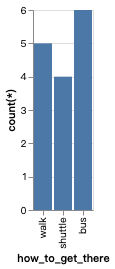




[Database]: cre_Drama_Workshop_Groups
[NL Question]: Give me a bar chart for mean product price of each product name , show from low to high by the total number .
[Chart Template]: visualize bar select [x], [agg(y)] from products where [w] group by [y] bin [x] by [i] order by [y] asc
[Predicted VIS Query]: visualize bar select product_name , avg(product_price) from products group by product_name order by avg(product_price) asc
[The Ground Truth VIS Query]: Visualize BAR SELECT Product_Name , avg(Product_Price) FROM PRODUCTS GROUP BY Product_Name ORDER BY avg(Product_Price) ASC
The Predicted VIS:


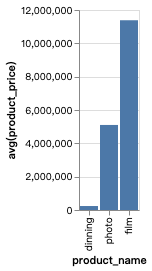




[Database]: hr_1
[NL Question]: For those employees whose salary is in the range of 8000 and 12000 and commission is not null or department number does not equal to 40 , give me the comparison about the average of salary over the hire_date bin hire_date by weekday , and I want to order in asc by the Y-axis .
[Chart Template]: visualize bar select [x], [agg(y)] from employees where [w] group by [y] bin [x] by [i] order by [y] asc
[Predicted VIS Query]: visualize bar select hire_date , avg(salary) from employees where salary between 8000 and 12000 and commission_pct != 'null' or department_id != 40 order by avg(salary) asc bin hire_date by weekday
[The Ground Truth VIS Query]: Visualize BAR SELECT HIRE_DATE , AVG(SALARY) FROM employees WHERE salary BETWEEN 8000 AND 12000 AND commission_pct != "null" OR department_id != 40  ORDER BY AVG(SALARY) ASC BIN HIRE_DATE BY WEEKDAY
The Predicted VIS:


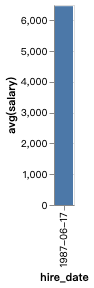




[Database]: store_1
[NL Question]: List the name of all playlist , and count them by a bar chart , sort Y from high to low order please .
[Chart Template]: visualize [c] select [x], [agg(y)] from playlists where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select name , count(name) from playlists group by name order by count(name) desc
[The Ground Truth VIS Query]: Visualize BAR SELECT name , COUNT(name) FROM playlists GROUP BY name ORDER BY COUNT(name) DESC
The Predicted VIS:


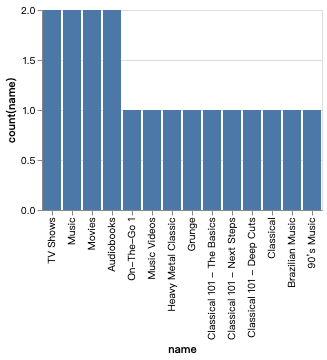




[Database]: product_catalog
[NL Question]: Which catalog contents has price above 700 dollars ? Show their catalog entry names and capacities , I want to list in descending by the y-axis .
[Chart Template]: visualize bar select [x], [agg(y)] from catalog_contents where [w] group by [y] bin [x] by [i] order by [y] desc
[Predicted VIS Query]: visualize bar select catalog_entry_name , capacity from catalog_contents where price_in_dollars > 700 order by capacity desc
[The Ground Truth VIS Query]: Visualize BAR SELECT catalog_entry_name , capacity FROM Catalog_Contents WHERE price_in_dollars > 700 ORDER BY capacity DESC
The Predicted VIS:


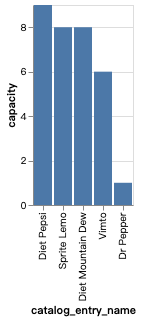




[Database]: cre_Theme_park
[NL Question]: List all the possible ways to get to attractions , together with the number of attractions accessible by these methods . Visualize by bar chart .
[Chart Template]: visualize bar select [x], [agg(y)] from [d] where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select how_to_get_there , count(*) from tourist_attractions group by how_to_get_there
[The Ground Truth VIS Query]: Visualize BAR SELECT How_to_Get_There , COUNT(*) FROM Tourist_Attractions GROUP BY How_to_Get_There
The Predicted VIS:


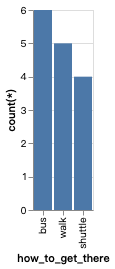




[Database]: candidate_poll
[NL Question]: Visualize a bar chart about the distribution of Date_of_Birth and Weight .
[Chart Template]: visualize bar select [x], [agg(y)] from [d] where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select date_of_birth , weight from people
[The Ground Truth VIS Query]: Visualize BAR SELECT Date_of_Birth , Weight FROM people
The Predicted VIS:


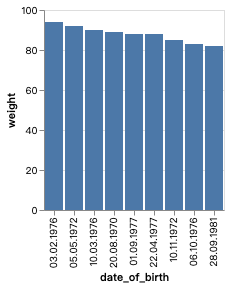




[Database]: hr_1
[NL Question]: For those employees whose salary is in the range of 8000 and 12000 and commission is not null or department number does not equal to 40 , return a bar chart about the distribution of hire_date and the amount of hire_date bin hire_date by weekday , and I want to order in descending by the y axis .
[Chart Template]: visualize bar select [x], [agg(y)] from employees where [w] group by [y] bin [x] by [i] order by [y] desc
[Predicted VIS Query]: visualize bar select hire_date , count(hire_date) from employees where salary between 8000 and 12000 and commission_pct != 'null' or department_id != 40 order by count(hire_date) desc bin hire_date by weekday
[The Ground Truth VIS Query]: Visualize BAR SELECT HIRE_DATE , COUNT(HIRE_DATE) FROM employees WHERE salary BETWEEN 8000 AND 12000 AND commission_pct != "null" OR department_id != 40  ORDER BY COUNT(HIRE_DATE) DESC BIN HIRE_DATE BY WEEKDAY
The Predicted VIS:


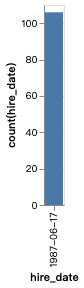




[Database]: bike_1
[NL Question]: Show maximal lat from each city
[Chart Template]: visualize [c] select [x], [agg(y)] from station where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select city , max(lat) from station group by city
[The Ground Truth VIS Query]: Visualize BAR SELECT city , max(lat) FROM station GROUP BY city
The Predicted VIS:


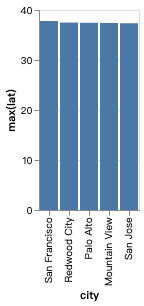




[Database]: hr_1
[NL Question]: For those employees who did not have any job in the past , draw a bar chart about the distribution of hire_date and the sum of salary bin hire_date by time , order from low to high by the Y .
[Chart Template]: visualize bar select [x], [agg(y)] from employees where [w] group by [y] bin [x] by [i] order by [y] asc
[Predicted VIS Query]: visualize bar select hire_date , sum(salary) from employees where employee_id not in (select employee_id from job_history) order by sum(salary) asc bin hire_date by month
[The Ground Truth VIS Query]: Visualize BAR SELECT HIRE_DATE , SUM(SALARY) FROM employees WHERE employee_id NOT IN (SELECT employee_id FROM job_history)  ORDER BY SUM(SALARY) ASC BIN HIRE_DATE BY MONTH
The Predicted VIS:


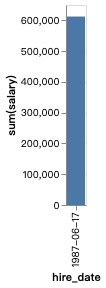




[Database]: hr_1
[NL Question]: For those employees whose salary is in the range of 8000 and 12000 and commission is not null or department number does not equal to 40 , a line chart shows the trend of manager_id over hire_date , and I want to show X-axis in ascending order .
[Chart Template]: visualize line select [x], [agg(y)] from employees where [w] group by [x] bin [x] by [i] order by [x] asc
[Predicted VIS Query]: visualize line select hire_date , manager_id from employees where salary between 8000 and 12000 and commission_pct != 'null' or department_id != 40 order by hire_date asc
[The Ground Truth VIS Query]: Visualize LINE SELECT HIRE_DATE , MANAGER_ID FROM employees WHERE salary BETWEEN 8000 AND 12000 AND commission_pct != "null" OR department_id != 40 ORDER BY HIRE_DATE ASC
The Predicted VIS:


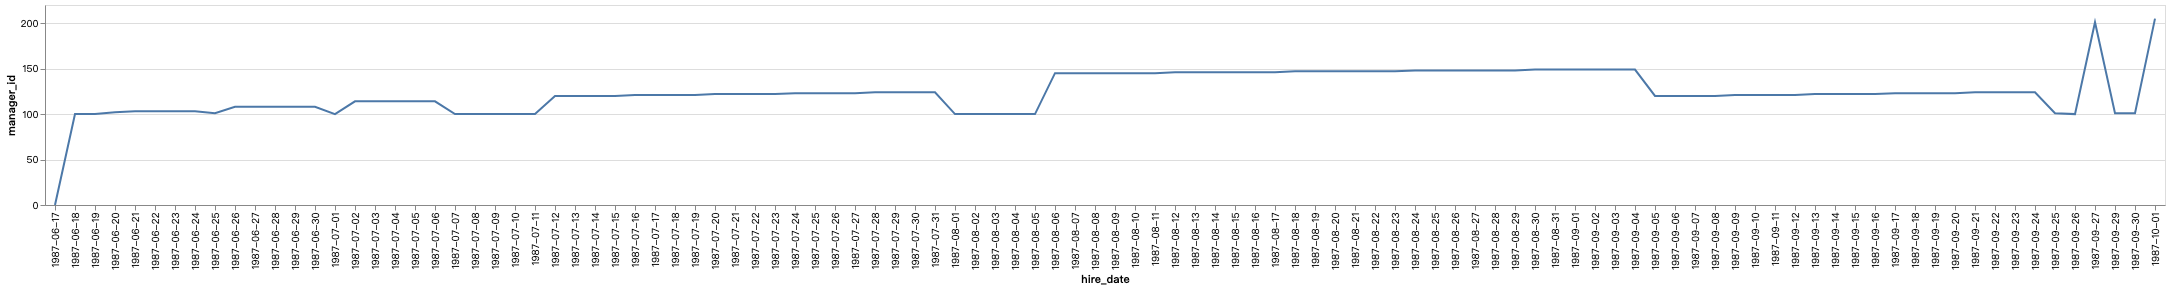




[Database]: university_basketball
[NL Question]: Bar chart x axis acc road y axis total number of school id , order in descending by the total number of school id .
[Chart Template]: visualize [c] select [x], [agg(y)] from basketball_match where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select acc_road , sum(school_id) from basketball_match group by acc_road order by sum(school_id) desc
[The Ground Truth VIS Query]: Visualize BAR SELECT ACC_Road , SUM(School_ID) FROM basketball_match GROUP BY ACC_Road ORDER BY SUM(School_ID) DESC
The Predicted VIS:


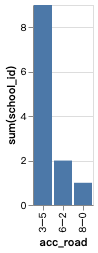




[Database]: hr_1
[NL Question]: For those employees who was hired before 2002-06-21 , give me the comparison about the sum of department_id over the hire_date bin hire_date by weekday by a bar chart , sort sum department id in ascending order .
[Chart Template]: visualize bar select [x], [agg(y)] from employees where [w] group by [y] bin [x] by [i] order by [y] asc
[Predicted VIS Query]: visualize bar select hire_date , sum(department_id) from employees where hire_date < '2002-06-21' order by sum(department_id) asc bin hire_date by weekday
[The Ground Truth VIS Query]: Visualize BAR SELECT HIRE_DATE , SUM(DEPARTMENT_ID) FROM employees WHERE hire_date < '2002-06-21'  ORDER BY SUM(DEPARTMENT_ID) ASC BIN HIRE_DATE BY WEEKDAY
The Predicted VIS:


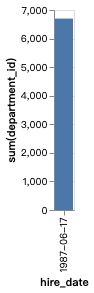




[Database]: university_basketball
[NL Question]: Draw a bar chart about the distribution of ACC_Road and the amount of ACC_Road , and group by attribute ACC_Road .
[Chart Template]: visualize [c] select [x], [agg(y)] from basketball_match where [w] group by [xy] bin [x] by [i] order by [xy] [t]
[Predicted VIS Query]: visualize bar select acc_road , count(acc_road) from basketball_match group by acc_road
[The Ground Truth VIS Query]: Visualize BAR SELECT ACC_Road , COUNT(ACC_Road) FROM basketball_match GROUP BY ACC_Road
The Predicted VIS:


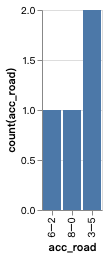

In [16]:
nl_acc = []
nl_chart_acc = []

test_result = []  # tvBench_id, chart_type, hardness, ifChartTemplate, ifRight=1

only_nl_cnt = 0
only_nl_match = 0

nl_template_cnt = 0
nl_template_match = 0
i = 0

create_vis = VisRendering()

for index, row in test_df.iterrows():
    gold_query = row['labels'].lower()

    src = row['source'].lower()
    i += 1

    tok_types = row['token_types']

    translation, attention, enc_attention = translate_sentence_with_guidance(
        row['db_id'], gold_query.split(' ')[gold_query.split(' ').index('from') + 1],
        src, SRC, TRG, TOK_TYPES, tok_types, SRC, model, db_tables_columns, device, my_max_length
    )

    pred_query = ' '.join(translation).replace(' <eos>', '').lower()
    old_pred_query = pred_query

    if '[c]' not in src:
        # with template
        pred_query = postprocessing(gold_query, pred_query, True, src)

        nl_template_cnt += 1

        if ' '.join(gold_query.replace('"', "'").split()) == ' '.join(pred_query.replace('"', "'").split()):
            print('=========================================================\n')
            print('[Database]:', row['db_id'])
            print('[NL Question]:', row['question'])
            print('[Chart Template]:', row['query_template'])
            print('[Predicted VIS Query]:',' '.join(pred_query.replace('"', "'").split()))
            print('[The Ground Truth VIS Query]:', row['query'])
            
            predict_query = ' '.join(pred_query.replace('"', "'").split())                      
            vis_query = create_vis.parse_output_query(
                path_to_db = './dataset/database/',
                db_id = row['db_id'],
                table_id = predict_query.split()[predict_query.split().index('from')-1],
                query = predict_query
            )

            data4vis = create_vis.query_sqlite3(
                './dataset/database/',
                row['db_id'],
                vis_query['data_part']['sql_part']
            )
            
            print('The Predicted VIS:')
            create_vis.render_vis(data4vis, vis_query)
            print('\n')
            
        else:
            pass

    if '[c]' in src:
        # without template
        pred_query = postprocessing(gold_query, pred_query, False, src)

        only_nl_cnt += 1
        if ' '.join(gold_query.replace('"', "'").split()) == ' '.join(pred_query.replace('"', "'").split()):
            print('=========================================================\n')
            print('[Database]:', row['db_id'])
            print('[NL Question]:', row['question'])
            print('[Chart Template]:', row['query_template'])
            print('[Predicted VIS Query]:',' '.join(pred_query.replace('"', "'").split()))
            print('[The Ground Truth VIS Query]:', row['query'])
            
            predict_query = ' '.join(pred_query.replace('"', "'").split())                                                                     
            vis_query = create_vis.parse_output_query(
                path_to_db = './dataset/database/',
                db_id = row['db_id'],
                table_id = predict_query.split()[predict_query.split().index('from')-1],
                query = predict_query
            )

            data4vis = create_vis.query_sqlite3(
                './dataset/database/',
                row['db_id'],
                vis_query['data_part']['sql_part']
            )

            print('The Predicted VIS:')
            create_vis.render_vis(data4vis, vis_query)
            print('\n')
            
        else:
            pass
    
    

    #show top-20 testing cases.
    if index > 20:
        break
